In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

width = 12
height = 7
plt.rcParams["figure.figsize"] = (width, height)


from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import tflscripts
import json
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from scipy.spatial.distance import cdist
import math

In [137]:
configuration = tflscripts.read_configuration()

dataset_path = '../datasets/robotics-final-complete/'
device = '128.237.247.134'
df = pd.read_pickle(dataset_path + device + '.p')
# df_labels = pd.read_pickle(dataset_path + device + '_labels.p')
# df['label'] = df_labels['label']

In [138]:
sensor_channels = [
    'MICROPHONE_fft',
    'ACCEL_fft',
    'EMI',
    'MAGNETO',
    'GEYE',
    'COLOR',
    'TEMPERATURE',
    'IRMOTION',
    'RSSI',
    'HUMIDITY',
    'BAROMETER'
]
activities = [
    "Dishes",
    "Microwave",
    "Coffee",
    "Null",
#         "Faucet",
    "Kettle",
#         "Phone ringing",
    "Chopping food",
    "Conversation",
    "Eating popcorn",
#         "Microwave door opened",
#         "Microwave door closed",
#         "Cupboard door opened",
#         "Cupboard door closed",
#         "Microwave button press",
#         "Taking ice",
    "Making popcorn in microwave",
#         "Room lights off",
    "Knocking",
#         "Frequency sweep",
    "Phone vibrating"
]

channel_anomalies = {}

for channel in sensor_channels:
    value_columns = df.filter(regex=channel).columns

    null_df = df.loc[df.label == configuration['activities'].index('Null')]
    null_mean = null_df[value_columns].mean()
    null_std = null_df[value_columns].std()

    anomalies = (((df[value_columns] - null_mean) / null_std) ** 2).sum(axis=1).apply(np.sqrt)
    channel_anomalies[channel] = anomalies

anomalies = pd.DataFrame(channel_anomalies)
anomalies['label'] = [configuration['activities'][int(i)] for i in df.label]
anomalies = anomalies.sort_values(['label'])
anomalies = anomalies.loc[anomalies.label.isin(activities)]
anomalies = anomalies.reset_index()

In [139]:
labels = anomalies.label.unique().tolist()
anomalies['label_'] = [1000 if labels.index(l) % 2 == 0 else 0 for l in anomalies['label']]

(0, 1000)

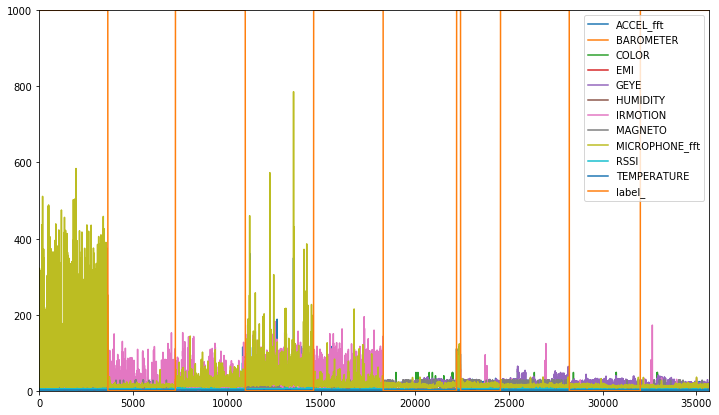

In [140]:
anomalies.filter(regex='|'.join(sensor_channels) + '|label_').plot()
plt.ylim(0,1000)

In [142]:
for label in labels:
    print(label, np.mean(anomalies.loc[anomalies.label == label].index))

Chopping food 1823.5
Coffee 5446.5
Conversation 9107.0
Dishes 12788.0
Eating popcorn 16460.5
Kettle 20268.0
Knocking 22329.0
Making popcorn in microwave 23498.0
Microwave 26393.5
Null 30118.5
Phone vibrating 33838.5


/home/giotto/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4234: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above
/home/giotto/.local/lib/python3.5/site-packages/matplotlib/cbook.py:2058: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
/home/giotto/.local/lib/python3.5/site-packages/matplotlib/cbook.py:2065: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)
/home/giotto/.local/lib/python3.5/site-packages/matplotlib/cbook.py:2074: RuntimeWarning: invalid value encountered in greater
  np.compress(x > stats['whishi'], x)


(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 16 Text xticklabel objects>)

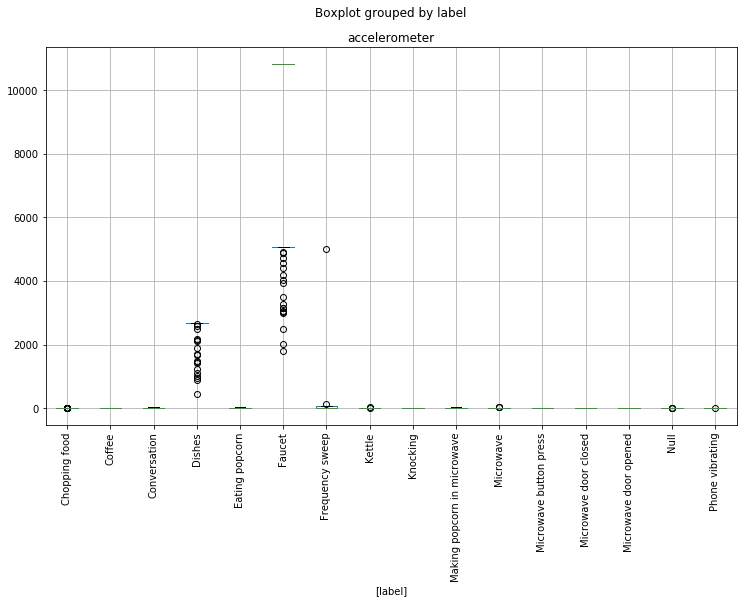

In [165]:
anomalies.filter(regex='accelerometer|label').boxplot(by='label')
plt.xticks(rotation = 90)

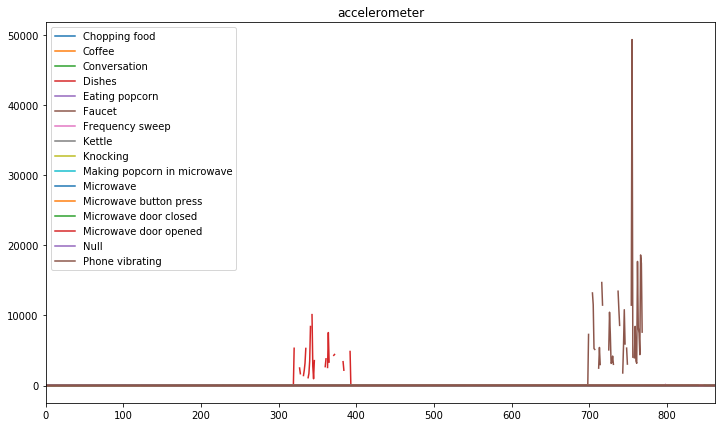

In [166]:
for anomaly_type in [
    'accelerometer'
]:
    reshaped_values = {}
    max_length = 0
    for label in anomalies.label.unique():
        values = anomalies.loc[anomalies.label == label][anomaly_type].values
        complete = np.zeros(max_length)
        complete = np.concatenate([complete, values])

        reshaped_values[label] = complete
        max_length += len(values)

    for label in reshaped_values:
        values = reshaped_values[label]
        arr = np.zeros(max_length)
        arr[:len(values)] = values
        reshaped_values[label] = arr

    pd.DataFrame(reshaped_values).plot()
    plt.title(anomaly_type)